# Preprocessing

## Traitement des valeus manquantes

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv("../data/train.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Il n'y a que 2 lignes valeurs manquantes pour la colonne 'Embarked', donc on va décider de le supprimer

In [50]:
print(df.shape)
df_cleaned = df.dropna(subset=['Embarked'])
print(df_cleaned.shape)
df_cleaned = df_cleaned.drop(['Name', 'Ticket', 'Cabin'], axis=1)

(891, 12)
(889, 12)


On va aussi transformé la colonnes Cabin pour que ce soit juste le pont qui soit indiqué

In [51]:
# df_cleaned['Cabin'] = df_cleaned['Cabin'].str[0]
# df_cleaned.head()

On va choisir de faire une imputation pour les valeurs manquantes de la colonne 'Age' vu qu'il y a 20% de valeurs manquantes

On va en même temps faire passer les données dans une chaîne de transformation pour l'imputation et la standardisation

In [62]:
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [61]:
# Séparation des types de colonnes
num_cols = df_cleaned.select_dtypes(include=['number']).columns
cat_cols = df_cleaned.select_dtypes(exclude=['number']).columns

print(num_cols)
print(cat_cols)

Index(['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')
Index(['Sex', 'Embarked'], dtype='object')


In [ ]:
# pipeline pour gérer les valeurs manquantes et transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', KNNImputer(n_neighbors=5)),
            ('scaler', StandardScaler())
        ]), num_cols),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(drop='first'))
        ]), cat_cols)
    ]
)


# Appliquer le pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
df_transformed = pipeline.fit_transform(df_cleaned)

df_transformed.head()


In [70]:
# Appliquer le pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
trans_results = pipeline.fit_transform(df_cleaned)

In [73]:
# Transformaton de trans_result en Dataframe
onehot = pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['encoder']
cat_names = onehot.get_feature_names_out(cat_cols)
all_names = list(num_cols) + list(cat_names)
print(all_names)

['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_male', 'Embarked_Q', 'Embarked_S']


In [74]:
df_transformed = pd.DataFrame(trans_results, columns=all_names, index=df_cleaned.index)

In [75]:
df_transformed.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,-1.732505,-0.786961,0.825209,-0.574953,0.431350,-0.474326,-0.500240,1.0,0.0,1.0
1,-1.728611,1.270711,-1.572211,0.631107,0.431350,-0.474326,0.788947,0.0,0.0,0.0
2,-1.724718,1.270711,0.825209,-0.273438,-0.475199,-0.474326,-0.486650,0.0,0.0,1.0
3,-1.720825,1.270711,-1.572211,0.404971,0.431350,-0.474326,0.422861,0.0,0.0,1.0
4,-1.716931,-0.786961,0.825209,0.404971,-0.475199,-0.474326,-0.484133,1.0,0.0,1.0


## Traitement des outliers

### Visualisation des outliers

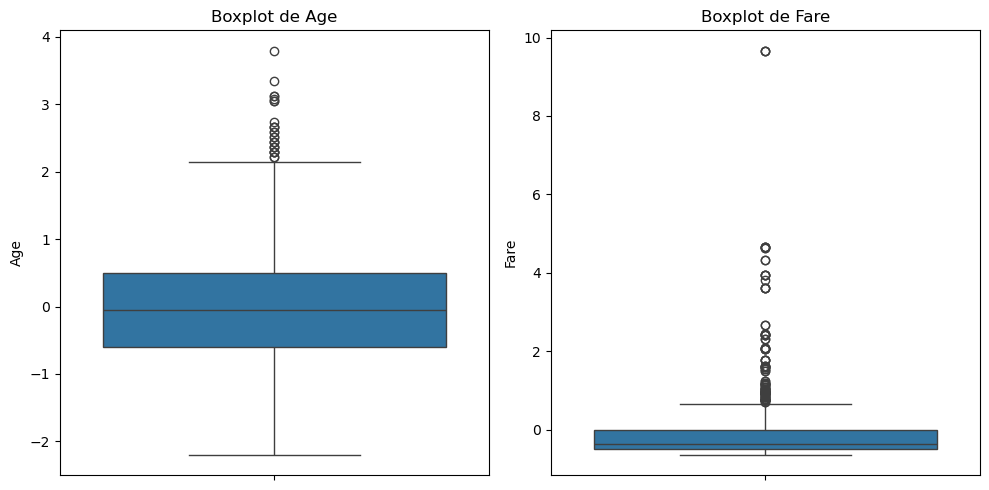

In [76]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.boxplot(y=df_transformed['Age'])
plt.title("Boxplot de Age")
plt.subplot(1, 2, 2)
sns.boxplot(y=df_transformed['Fare'])
plt.title("Boxplot de Fare")
plt.tight_layout()
plt.show()

### Utilisation de la méthode IQR

In [77]:
# fonction pour detecter les outliers
def detect_outliers(data: pd.DataFrame, col: str):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    upper_bound = Q3 + 1.5 * IQR
    lower_bound = Q1 - 1.5 * IQR
    outliers = data[
        (data[col] < lower_bound) 
        | (data[col] > upper_bound)
    ]

    return outliers, lower_bound, upper_bound


In [81]:
# Appliquer à 'Age' et 'Fare'
age_outliers, age_low, age_upp = detect_outliers(df_transformed, 'Age')
fare_outliers, fare_low, fare_upp = detect_outliers(df_transformed, 'Fare')

print(f"Outliers pour Age: limites[{age_low} : {age_upp}]")
display(age_outliers)

print(f"Outliers pour Fare: limites[{fare_low} : {fare_upp}]")
display(fare_outliers)

Outliers pour Age: limites[-2.2559001134970345 : 2.1462201843388566]


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
33,-1.604027,-0.786961,-0.373501,2.741712,-0.475199,-0.474326,-0.434807,1.0,0.0,1.0
54,-1.522268,-0.786961,-1.572211,2.666334,-0.475199,0.765897,0.601627,1.0,0.0,0.0
94,-1.366537,-0.786961,0.825209,2.214061,-0.475199,-0.474326,-0.500240,1.0,0.0,1.0
96,-1.358751,-0.786961,-1.572211,3.118606,-0.475199,-0.474326,0.051491,1.0,0.0,0.0
116,-1.280885,-0.786961,0.825209,3.080917,-0.475199,-0.474326,-0.490173,1.0,1.0,0.0
170,-1.070649,-0.786961,-1.572211,2.364819,-0.475199,-0.474326,0.028253,1.0,0.0,1.0
232,-0.829266,-0.786961,-0.373501,2.214061,-0.475199,-0.474326,-0.374408,1.0,0.0,1.0
252,-0.751401,-0.786961,-1.572211,2.440197,-0.475199,-0.474326,-0.111672,1.0,0.0,1.0
275,-0.661856,1.270711,-1.572211,2.515576,0.431350,-0.474326,0.923335,0.0,0.0,1.0
280,-0.642389,-0.786961,0.825209,2.666334,-0.475199,-0.474326,-0.490173,1.0,1.0,0.0


Outliers pour Fare: limites[-1.1849752350109237 : 0.6756578715438935]


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
1,-1.728611,1.270711,-1.572211,0.631107,0.431350,-0.474326,0.788947,0.0,0.0,0.0
27,-1.627386,-0.786961,-1.572211,-0.801090,2.244449,2.006119,4.648791,1.0,0.0,1.0
31,-1.611813,1.270711,-1.572211,0.495425,0.431350,-0.474326,2.303708,0.0,0.0,0.0
34,-1.600133,-0.786961,-1.572211,-0.122681,0.431350,-0.474326,1.008145,1.0,0.0,0.0
52,-1.530055,1.270711,-1.572211,1.460273,0.431350,-0.474326,0.898589,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
846,1.561201,-0.786961,0.825209,0.254213,6.777195,2.006119,0.754050,1.0,0.0,1.0
849,1.572880,1.270711,-1.572211,0.932622,0.431350,-0.474326,1.147736,0.0,0.0,0.0
856,1.600133,1.270711,-1.572211,1.158758,0.431350,0.765897,2.673067,0.0,0.0,1.0
863,1.627386,-0.786961,0.825209,0.857243,6.777195,2.006119,0.754050,0.0,0.0,1.0


In [82]:
print("Taux de survie pour les outliers de Fare: ")
fare_outliers_indices = fare_outliers.index
print(df_transformed.loc[fare_outliers_indices, ["Fare", "Survived", "Pclass"]])

Taux de survie pour les outliers de Fare: 
         Fare  Survived    Pclass
1    0.788947  1.270711 -1.572211
27   4.648791 -0.786961 -1.572211
31   2.303708  1.270711 -1.572211
34   1.008145 -0.786961 -1.572211
52   0.898589  1.270711 -1.572211
..        ...       ...       ...
846  0.754050 -0.786961  0.825209
849  1.147736  1.270711 -1.572211
856  2.673067  1.270711 -1.572211
863  0.754050 -0.786961  0.825209
879  1.028027  1.270711 -1.572211

[114 rows x 3 columns]


On Choisi de faire du capping pour traiter les outliers de age car 80 ans c'est tout a fait plausible, on fera de même pour 'Fare'

In [85]:
# Capping pour 'Age'
df_capped = df_transformed.copy()
age_upper_lim = detect_outliers(df_transformed, 'Age')[2]

df_capped['Age'] = np.where(df_capped['Age'] > age_upper_lim, age_upper_lim, df_capped['Age'])

fare_upper_limit = detect_outliers(df_transformed, 'Fare')[2]
df_capped['Fare'] = np.where(df_capped['Fare'] > fare_upper_limit, fare_upper_limit, df_capped['Fare'])



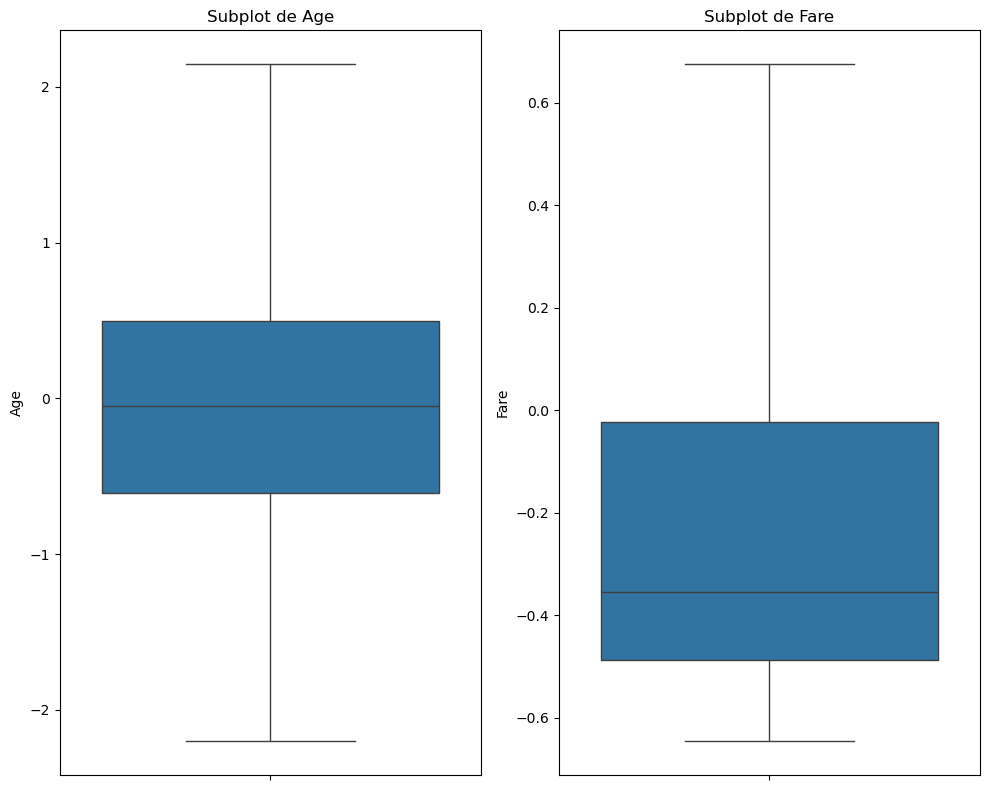

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Subplot de Age")
sns.boxplot(df_capped['Age'])
plt.subplot(1, 2, 2)
plt.title("Subplot de Fare")
sns.boxplot(df_capped['Fare'])
plt.tight_layout()
plt.show()